# Multiclass semantic segmentation with U-Net

## 1.0 Import libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
from torch import nn
from torchgeo.samplers import RandomGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples
from torchgeo.datasets import RasterDataset
from torchsummary import summary
#import pylab as plt
# torch.cuda.is_available()

## 2.0 Check CUDA availability

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
print()

Using device: cpu



In [4]:
#Additional Info when using cuda
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

## 3.0 Load and prepare dataset

In [5]:
# Create CLASS for images and labels
class BengaluruDatasetImages(RasterDataset):
    """
    Load image data that ends in *.tif
    """
    filename_glob = "*.tif"
    

class BengaluruDatasetLabels(RasterDataset):
    """
    Load label data that ends in *.tif
    """
    is_image = False
    filename_glob = "*.tif"

In [6]:
# base path of the dataset
TRAIN_PATH = os.path.join("Data", "Train")
VALID_PATH = os.path.join("Data", "Valid")
TEST_PATH = os.path.join("Data", "Test")
#tr_labels = lambda x: x[:,0,:,:].long()

In [7]:
# Create CLASS for image and label transformation

class TransformBengaluruImages(nn.Module):
    """
    Apply Min and Max scale to the image
    """

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        inputs["image"] -= inputs["image"].min()
        inputs["image"] /= inputs["image"].max()
        
        return inputs
    
class TransformBengaluruLabels(nn.Module):
    """
    Create additional dimensions for the labels np arrays
    """

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        # Batch
        if inputs["mask"].ndim == 4:
            inputs["mask"] = (inputs["mask"][:,0,:,:]).long()
        # Sample
        else:
            inputs["mask"] = (inputs["mask"][0,:,:]).long()
        
        return inputs



In [8]:
# Create Train and Test datasets
tr_im = BengaluruDatasetImages(os.path.join(TRAIN_PATH, "Images"), transforms=TransformBengaluruImages())
tr_la = BengaluruDatasetLabels(os.path.join(TRAIN_PATH, "Labels"), transforms=TransformBengaluruLabels())

TRAIN_DS = tr_im & tr_la

# Create Train and Test datasets
vl_im = BengaluruDatasetImages(os.path.join(VALID_PATH, "Images"), transforms=TransformBengaluruImages())
vl_la = BengaluruDatasetLabels(os.path.join(VALID_PATH, "Labels"), transforms=TransformBengaluruLabels())

VALID_DS = vl_im & vl_la

ts_im = BengaluruDatasetImages(os.path.join(TEST_PATH, "Images"), transforms=TransformBengaluruImages())
ts_la = BengaluruDatasetLabels(os.path.join(TEST_PATH, "Labels"), transforms=TransformBengaluruLabels())

TEST_DS = ts_im & ts_la

In [9]:
# Define dataset, batch, and image sizes
DATASET_SIZE = 512
BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
# BATCH_SIZE = 128
IMG_SIZE = 128

In [11]:
train_sampler = RandomGeoSampler(TRAIN_DS, size=IMG_SIZE, length=DATASET_SIZE)
valid_sampler = RandomGeoSampler(VALID_DS, size=IMG_SIZE, length=72)
test_sampler = RandomGeoSampler(TEST_DS, size=IMG_SIZE, length=72)

train_dl = DataLoader(TRAIN_DS, BATCH_SIZE, sampler=train_sampler, collate_fn=stack_samples)
valid_dl = DataLoader(VALID_DS, VALID_BATCH_SIZE, sampler=valid_sampler, collate_fn=stack_samples)
test_dl  = DataLoader(TEST_DS, 1, sampler=test_sampler, collate_fn=stack_samples)

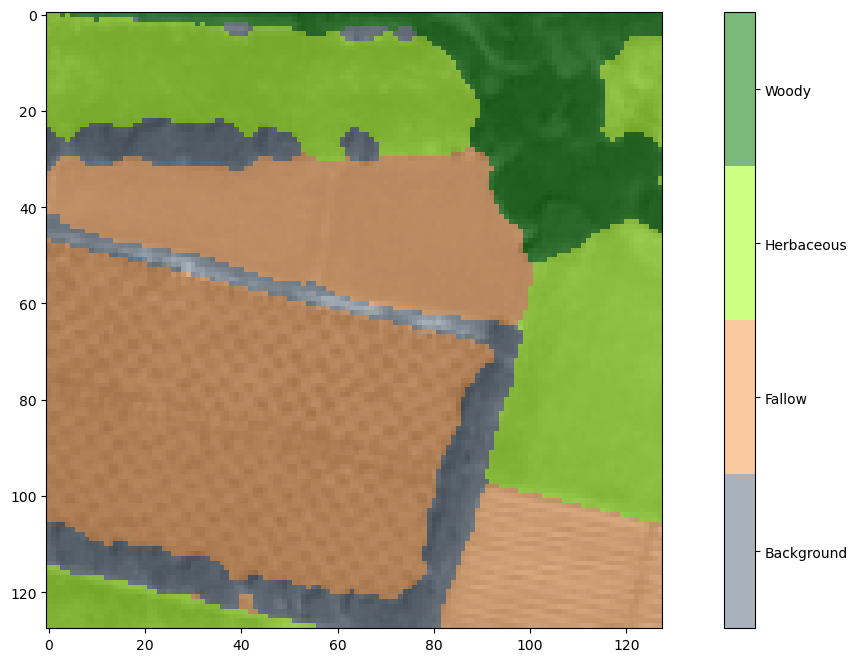

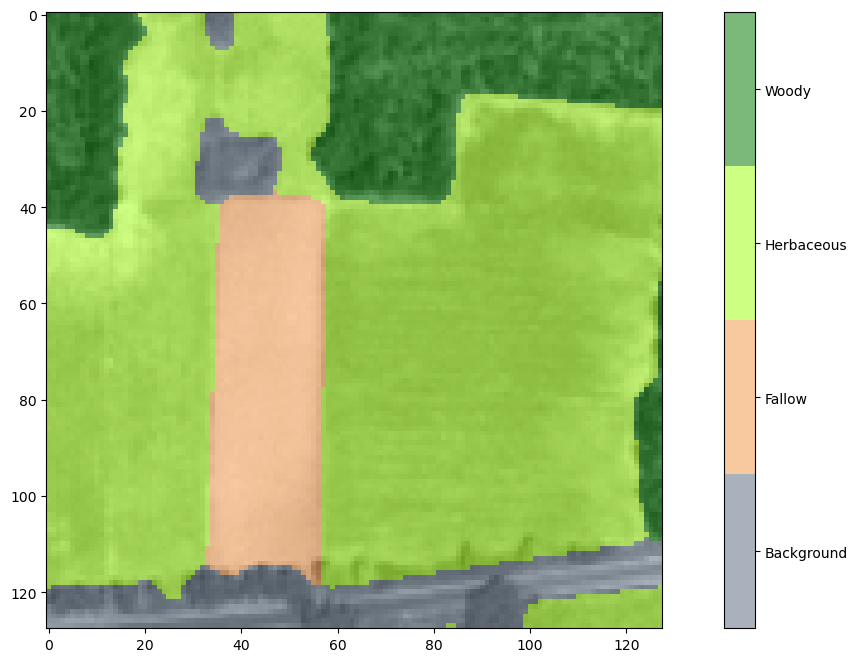

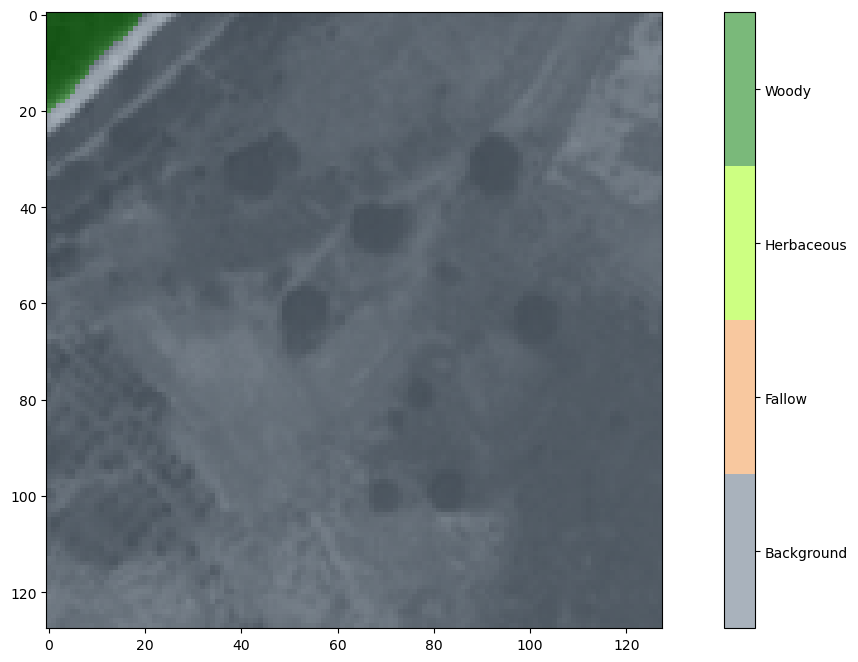

In [12]:
import matplotlib as mpl
cmap_custom = (mpl.colors.ListedColormap(['slategray', 'sandybrown', 'greenyellow', 'forestgreen', 'red']))
        # .with_extremes(over='0.25', under='0.75'))
def visualize(image, mask):
    """PLot images in one row."""
    fig = plt.figure(figsize=(16, 8))
    #plt.imshow(image[0].transpose(0,2), vmin=0, vmax=1)
    image /= image.numpy().max()
    plt.imshow(image, cmap='gray')
    #plt.imshow(image[0])
    if mask.max()>0:
        tmp_mask = mask.clone()
        tmp_mask[tmp_mask==255] = 4
        plt.imshow(mask/4, alpha=0.6, cmap=cmap_custom, vmin=0, vmax=1, interpolation='nearest')
      
    cb = plt.colorbar(cmap=cmap_custom, ticks=np.array([0.1, 0.3, 0.5, 0.7]), boundaries=np.array([0., 0.2, 0.4, 0.6, 0.8]))
    # ticks=np.linspace(0.5/9, 3.5/9, 4), boundaries=np.linspace(0,4/9,5))
    cb.set_ticklabels(['Background', 'Fallow', 'Herbaceous', 'Woody'])
    plt.show()

for dl in [train_dl, valid_dl, test_dl]:
    for sample in dl:
        idx = 0
        image = sample["image"].moveaxis(1,3)[idx, :, :, 1]
        target = sample["mask"][idx, :, :]
        
        visualize(image, target)
        break

## 4.0 Model definition

### 4.1 UNET Class define

In [13]:
# Creat UNET CLASS
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 3, 1)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.conv4 = self.contract_block(128, 256, 3, 1)

        self.upconv4 = self.expand_block(256, 128, 3, 1)
        self.upconv3 = self.expand_block(128*2, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [14]:
# Example usage
in_channels = 5  # Number of input channels (e.g., for WV images)
out_channels = 4  # Number of output channels (e.g., number of classes)
test_model = UNET(in_channels, out_channels)
input_tensor = torch.randn(1, in_channels, 128, 128)  # Example input tensor
output_tensor = test_model(input_tensor)
print(output_tensor.shape)

torch.Size([1, 4, 128, 128])


### 4.2 View the summary of the model

In [15]:
unet_model =  UNET(in_channels=5, out_channels=4).to(DEVICE)

### 4.3 Define model parameters

In [15]:
sum_labels = {}

for _ in range(1):
    for i, x in enumerate(train_dl):
        for j in range(x['mask'].shape[0]):
            labels = x['mask']
            unique_labels, counts = torch.unique(x['mask'][j,:,:], return_counts=True)
            for l, c in zip(unique_labels, counts):
                sum_labels[l.item()] = sum_labels.get(l.item(), 0) + c.item()
            # if 255 in unique_labels:
            #     print(unique_labels)
            #     print(counts)
            #     image = x['image'].moveaxis(1,3)
            #     labels = x['mask']
            #     visualize(image[j,:,:,1], labels[j,:,:])
weights=[sum_labels[c] for c in range(4)]
print(weights)
print(weights/np.sum(weights))
weights = 1/np.array(weights)
print(weights/np.sum(weights))


[1994757, 877028, 2857751, 2658688]
[0.23780445 0.10455467 0.34068606 0.31695482]
[0.21174123 0.48159499 0.14779884 0.15886493]


In [16]:
x['mask'].shape

torch.Size([64, 128, 128])

In [17]:
64*128*128

1048576

In [18]:
# LEARNING_RATE = 0.01
LEARNING_RATE = 0.001
num_epochs = 100
loss_fn = nn.CrossEntropyLoss(
	weight=torch.tensor(weights).float().to(DEVICE),
	ignore_index=255
)
# focal_loss = torch.hub.load(
# 	'adeelh/pytorch-multi-class-focal-loss',
# 	model='FocalLoss',
# 	# alpha=torch.tensor([1, 1., 0.5, 0.5]).to(DEVICE),
# 	alpha=torch.tensor(weights).float().to(DEVICE),
# 	gamma=2,
# 	reduction='mean',
# 	force_reload=False,
#     ignore_index=255
# )
# loss_fn = focal_loss.to(DEVICE)


opt = torch.optim.Adam(unet_model.parameters(), lr=LEARNING_RATE)

### 4.4 Create TRAIN function

In [19]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, iou_fn, epochs=1):
    start = time.time()
    model

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0
            running_acc_wo_bg = 0.0
            running_iou = 0.0

            step = 0

            # iterate over data
            for sampl in dataloader:
                x = sampl['image'].to(DEVICE)
                y = sampl['mask'].to(DEVICE)
                
                if x.isnan().any():
                    print('x nan')
                if y.isnan().any():
                    print('y nan')
                
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    
                    if outputs.isnan().any():
                        print('outputs nan')
                        break
                    loss = loss_fn(outputs, y)
                    

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)
                acc_wo_bg = acc_fn(outputs, y, ignore_classes=[0])
                iou = iou_fn(outputs, y)

                running_acc  += acc
                running_acc_wo_bg  += acc_wo_bg
                running_loss += loss
                running_iou += iou
                
                if step % 20 == 0:
                    # clear_output(wait=True)
                    # print('Current step: {}  Loss: {}  Acc: {} '.format(step, loss, acc))
                    print('Current step: {};  Loss: {:.3f};  Accuracy: {:.3f};  Accuracy wo BG: {:.3f}; IoU: {:.3f}; AllocMem (Mb): {:.3f}'.format(step, loss, acc, acc_wo_bg, iou, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())
            

            epoch_loss = running_loss / step
            epoch_acc = running_acc / step
            epoch_acc_wo_bg = running_acc_wo_bg / step
            epoch_iou = running_iou / step

            # print('Phase: {}; Loss: {:.3f}; Accuracy: {:.3f}; IoU: {:.3f}'.format(phase, epoch_loss, epoch_acc, epoch_acc_wo_bg, epoch_iou))
            print('Phase: {}; Loss: {:.3f}; Accuracy: {:.3f}; Accuracy wo BG: {:.3f}; IoU: {:.3f}'.format(phase, epoch_loss, epoch_acc, epoch_acc_wo_bg, epoch_iou))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb, ignore_classes=None):
    mask = torch.full_like(yb, True)
    if ignore_classes is not None:
        mask = torch.full_like(yb, True)
        for c in ignore_classes:
            mask = torch.logical_and(mask, yb!=c)
    numerator = ((predb.argmax(dim=1) == yb.to(DEVICE)).float()*mask).sum()
    denominator = torch.sum(mask)
    return numerator/denominator

def iou_metric(predb, yb):
    intersection = (torch.logical_and(predb.argmax(dim=1), yb.to(DEVICE).float())).sum(()).float()
    union = (torch.logical_or(predb.argmax(dim=1), yb.to(DEVICE)).float()).sum(()).float()
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou.mean()



### 4.5 Model training

In [20]:
train_loss, valid_loss = train(model=unet_model, 
                               train_dl=train_dl, 
                               valid_dl=valid_dl, 
                               loss_fn=loss_fn, 
                               optimizer=opt, 
                               acc_fn=acc_metric, 
                               iou_fn = iou_metric, 
                               epochs=num_epochs)

Epoch 1/100
----------
Phase: train; Loss: 1.850; Accuracy: 0.198; Accuracy wo BG: 0.133; IoU: 0.457
Phase: valid; Loss: 28840722.000; Accuracy: 0.361; Accuracy wo BG: 0.000; IoU: 0.000
Epoch 2/100
----------
Phase: train; Loss: 1.471; Accuracy: 0.290; Accuracy wo BG: 0.388; IoU: 0.745
Phase: valid; Loss: 261806.094; Accuracy: 0.274; Accuracy wo BG: 0.414; IoU: 0.663
Epoch 3/100
----------
Phase: train; Loss: 1.437; Accuracy: 0.212; Accuracy wo BG: 0.200; IoU: 0.552
Phase: valid; Loss: 39.738; Accuracy: 0.390; Accuracy wo BG: 0.486; IoU: 0.639
Epoch 4/100
----------
Phase: train; Loss: 1.402; Accuracy: 0.304; Accuracy wo BG: 0.180; IoU: 0.278
Phase: valid; Loss: 1.442; Accuracy: 0.206; Accuracy wo BG: 0.000; IoU: 0.000
Epoch 5/100
----------
Phase: train; Loss: 1.395; Accuracy: 0.236; Accuracy wo BG: 0.286; IoU: 0.642
Phase: valid; Loss: 1.413; Accuracy: 0.298; Accuracy wo BG: 0.000; IoU: 0.000
Epoch 6/100
----------
Phase: train; Loss: 1.407; Accuracy: 0.213; Accuracy wo BG: 0.105; Io

KeyboardInterrupt: 

### 4.6 Save Model

In [ ]:
torch.save(unet_model, os.path.join("UNET", 'unet_model_128px_100epoches.pt'))
torch.save(unet_model.state_dict(), os.path.join("UNET", 'unet_model_128px_100epoches_state_dict.pt'))

### 4.7 Plot Training and Validation Loss

In [ ]:
plt.plot([t.detach().cpu().numpy() for t in train_loss])

In [ ]:
plt.plot([t.detach().cpu().numpy() for t in valid_loss])

In [ ]:
plt.plot([t.detach().cpu().numpy() for t in valid_loss][1:])

### 4.8 Check predictions

In [ ]:
def compute_macro_f1(pred, target, num_classes):
    f1_list = []
    for cls in range(num_classes):
        true_positive = ((pred == cls) & (target == cls)).sum().item()
        false_positive = ((pred == cls) & (target != cls)).sum().item()
        false_negative = ((pred != cls) & (target == cls)).sum().item()

        precision = true_positive / (true_positive + false_positive + 1e-10)
        recall = true_positive / (true_positive + false_negative + 1e-10)
        
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        f1_list.append(f1)
    
    macro_f1 = sum(f1_list) / num_classes
    return macro_f1

In [ ]:
from statistics import mean
def compute_iou(pred, target, num_classes):
    iou_list = []
    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum().item()
        union = ((pred == cls) | (target == cls)).sum().item()
        iou = intersection / (union + 1e-10)
        iou_list.append(iou)
    return iou_list

In [ ]:
for dl in [test_dl]:
    for sample in dl:
        idx = 0
        image = sample["image"].moveaxis(1,3)[idx, :, :, 1]
        target = sample["mask"][idx, :, :]
        pred = unet_model(sample["image"].cuda()).cpu()[0]
        
        print("Actual")
        visualize(image, target)
        print("Predicted")
        visualize(image, torch.argmax(pred, 0))
        
        accuracy = (torch.argmax(pred, 0) == target).float().mean()

        correct_pred = (torch.argmax(pred, 0) == target).float()
        accuracy_wo_background = correct_pred[target!=0].mean()

        macroF1 = compute_macro_f1(torch.argmax(pred, 0), target, 4)
        
        iou_list = compute_iou(torch.argmax(pred, 0), target, 4)
        
        print(f"Test Accuracy: {accuracy:.4f}, "
              f"Test Accuracy wo BG: {accuracy_wo_background:.4f}, "
              f"Test MacroF1: {macroF1:.4f}, "
              f"Test mean IoU: {mean(iou_list)}")
        break

In [ ]:
test_acc = []
test_acc_wo_BG = []
test_mF1 = []
test_IoU = []
for sample in test_dl:
    # print(sample["image"].shape)
    # print(sample["mask"].shape)
    target = sample["mask"][0, :, :]
    pred = unet_model(sample["image"].cuda()).cpu()[0]
    
    accuracy = (torch.argmax(pred, 0) == target).float().mean()
    test_acc.append(accuracy.tolist())
    correct_pred = (torch.argmax(pred, 0) == target).float()
    accuracy_wo_background = correct_pred[target!=0].nanmean()
    test_acc_wo_BG.append(accuracy_wo_background.tolist())
    macroF1 = compute_macro_f1(torch.argmax(pred, 0), target, 4)
    test_mF1.append(macroF1)
    iou_list = compute_iou(torch.argmax(pred, 0), target, 4)
    test_IoU.append(mean(iou_list))

print(f"Average Test Accuracy: {mean(test_acc):.4f}\n"
      f"Average wo BG Test Accuracy: {np.nanmean(test_acc_wo_BG):.4f}\n"
      f"Average Test MacroF1: {mean(test_mF1):.4f}\n"
      f"Average Test mean IoU: {mean(test_IoU):.4f}")   

# Set the x axis label of the current axis.
plt.xlabel('Bacth No.')
# Set the y axis label of the current axis.
plt.ylabel('Metric')
# Set a title 
plt.title('Test Data set evaluation batch-wise')
# Display the figure.
plt.plot(range(1, len(test_acc)+1), test_acc, color='blue', linewidth = 1,  label = 'Accruacy')
plt.plot(range(1, len(test_acc_wo_BG)+1), test_acc_wo_BG, color='green', linewidth = 1,  label = 'Accruacy wo BG')
plt.plot(range(1, len(test_mF1)+1), test_mF1, color='yellow', linewidth = 1,  label = 'Macro F1')
plt.plot(range(1, len(test_IoU)+1), test_IoU, color='red', linewidth = 1,  label = 'IoU')
# show a legend on the plot
plt.legend()
plt.show()
    

In [ ]:
#Additional Info when using cuda
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')